In [2]:
from torchvision import datasets, transforms
import torch.nn as nn
import torch
import torch

from torchvision import datasets
from torchvision import transforms 
from torch import nn, optim

from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyL 
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import time
import copy
from torchvision import datasets, transforms, models
import torch                                                  #tensor related operations
import torchvision
#import os
#import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import torchvision
model = torchvision.models.resnet18(pretrained=True)

In [ ]:
model

In [ ]:
import torchsummary 

torchsummary.summary(model,(3,224,224))

In [13]:
data_dir = r'D:\a_small_project\VS_code_project\project_1\python_computer_vision\practical_start\archive_minor'


train_dir = data_dir + r'\seg_train\seg_train'
valid_dir = data_dir + r'\seg_test\seg_test'
test_dir = data_dir + r'\seg_test\seg_test'

# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),#
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset ,batch_size=32, shuffle=True, pin_memory=True)#,pin_memory=True,num_workers=8 试试
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, pin_memory=True)

In [20]:
# 以下对于rest net18可以跑通feature map绘制

model1 = torch.load(r'D:\a_small_project\VS_code_project\project_1\python_computer_vision\practical_start\Lecure_Use\restnet18_trained_on_intel6_scene')

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model1.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")
model = model1.to(device)





Total convolution layers: 17
conv_layers


In [ ]:
list(model1.children())

In [ ]:
import Image
image = Image.open(str(r'D:\a_small_project\VS_code_project\project_1\python_computer_vision\practical_start\archive_minor\seg_test\seg_test\buildings\20057.jpg'))
#

In [ ]:
conv_layers

In [29]:

from PIL import Image
image = Image.open(str(r'D:\a_small_project\VS_code_project\project_1\python_computer_vision\practical_start\archive_minor\seg_test\seg_test\buildings\20057.jpg'))
#
image = testing_transforms(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
# for feature_map in outputs:
#     print(feature_map.shape)



Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
17


In [ ]:
model1

In [33]:
outputs[1].squeeze(0).shape# 因为matplot绘画，这个第0维没用

torch.Size([64, 112, 112])

In [34]:
torch.sum(outputs[1].squeeze(0),0).shape # 

torch.Size([112, 112])

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


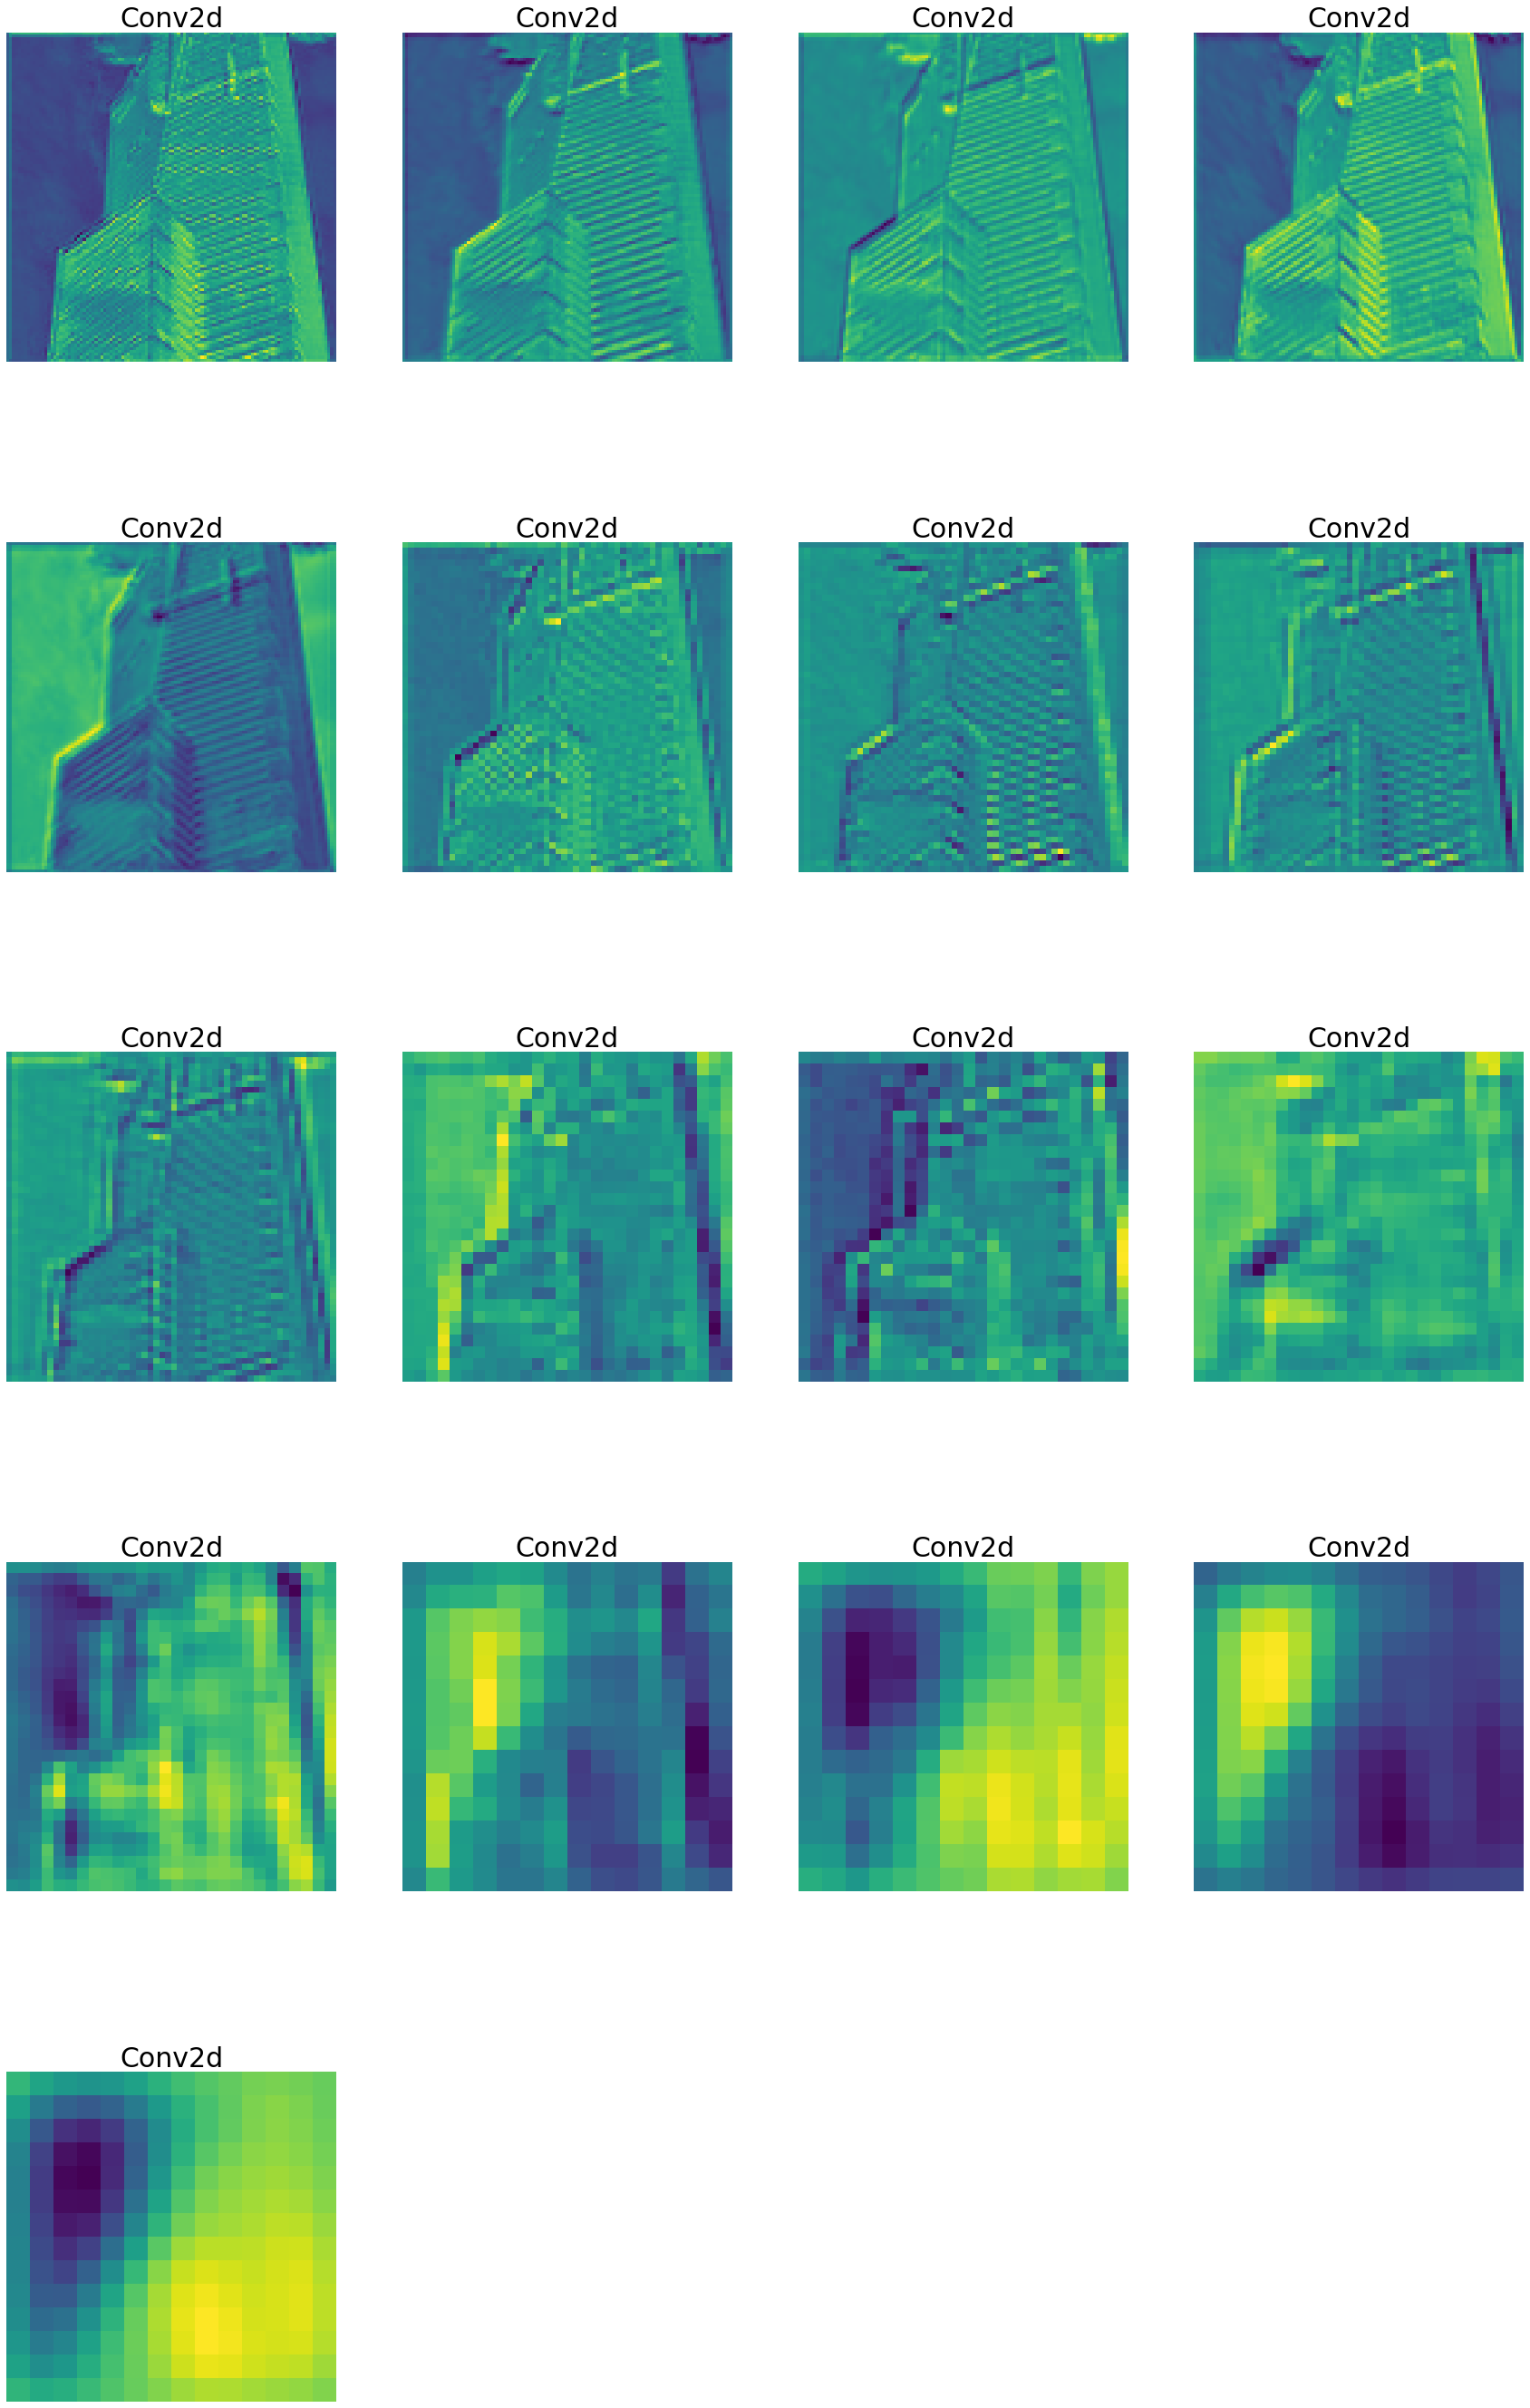

In [35]:

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
